In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import time
import numba
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import category_encoders as ce
import matplotlib.pyplot as plt
from scipy.stats import trim_mean

from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import (compute_scaling, compute_weights, reduce_mem_usage, 
                   compute_scales_by_level, compute_weights_by_level)
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from encoding import HierarchicalEncoder

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22"))

***
# Level 12

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .rename({"q":"y"}, axis=1))
data["sales"] = data.eval("y * sell_price")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 44 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ts_id             int16         
 1   item_id           int16         
 2   dept_id           int8          
 3   cat_id            int8          
 4   store_id          int8          
 5   state_id          int8          
 6   y                 int16         
 7   ds                datetime64[ns]
 8   snap_CA           int8          
 9   snap_TX           int8          
 10  snap_WI           int8          
 11  snap_CA_cum       int8          
 12  snap_TX_cum       int8          
 13  snap_WI_cum       int8          
 14  event_name_1      int8          
 15  sell_price        float32       
 16  regular_price     float32       
 17  price_iqr         float32       
 18  price_min         float32       
 19  price_max         float32       
 20  discount_norm     float32       
 21  price_

In [4]:
%%time
scales_by_level = compute_scales_by_level(scaling_input, valid_period[0])
weights_by_level = compute_weights_by_level(weighting_input, valid_period[0])

CPU times: user 1min 51s, sys: 42.6 s, total: 2min 34s
Wall time: 2min 34s


In [5]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':600,
    #'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**10-1,
    'learning_rate': 0.05,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    #"year_week",
    #"year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "no_stock_days",
    "sales",
]

categorical_features = {
    "item_id": ("y", ce.GLMMEncoder, None),
    #"item_id": "default",
    "store_id": "default",
    "state_id": "default",
    "dept_id": "default",
    "cat_id": "default",
    "event_name_1": "default",
    }

@numba.jit(nopython=True, nogil=True, fastmath=True)
def compute_nzeros(x):
    return np.sum(x==0)

@numba.jit(nopython=True, nogil=True, fastmath=True)
def compute_czeros(x):
    return np.sum(np.cumprod((x==0)[::-1]))/x.shape[0]

@numba.jit(nopython=True, nogil=True, fastmath=True)
def compute_sfreq(x):
    return np.sum(x!=0)/x.shape[0]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "window_functions":{
        "mean":   (None, [1,7,28], [7,14,21,28]),
        "median": (None, [1,7,14,28], [7,]),
        "std":    (None, [1,7,28], [7,28]),
        "kurt":   (None, [1,7,28], [7,28]),
        "czeros": (compute_czeros, [1,], [7,14,21,28,56]),
        "sfreq":  (compute_sfreq, [1,],  [7,14,21,28]),
    },
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["item_id","store_id"],
}

lagged_features_to_dropna = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features_to_dropna.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = list()
    for window_func,window_def in model_kwargs["window_functions"].items():
        _,window_shifts,window_sizes = window_def
        if window_func in ["mean","median","std","min","max"]:
            rw_features.extend([f"{window_func}{window_size}_shift{window_shift}"
                                for window_size in window_sizes
                                for window_shift in window_shifts])
    lagged_features_to_dropna.extend(rw_features)

***
## training with many seeds

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 2 #
####################################################################################################
Building the features
Elapsed time: 12.531729809443156 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.037488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 64
Elapsed time: 52.95949349006017 [min]
Predicting
Elapsed time: 14.620028126239777 [min]
wrmsse: 0.4903467142665861
wrmsseL12: 0.8173534161113774
{'root': 0.1902929355533325, ('state_id',): 0.31099972403305104, ('store_id',): 0.43942531157618175, ('cat_id',): 

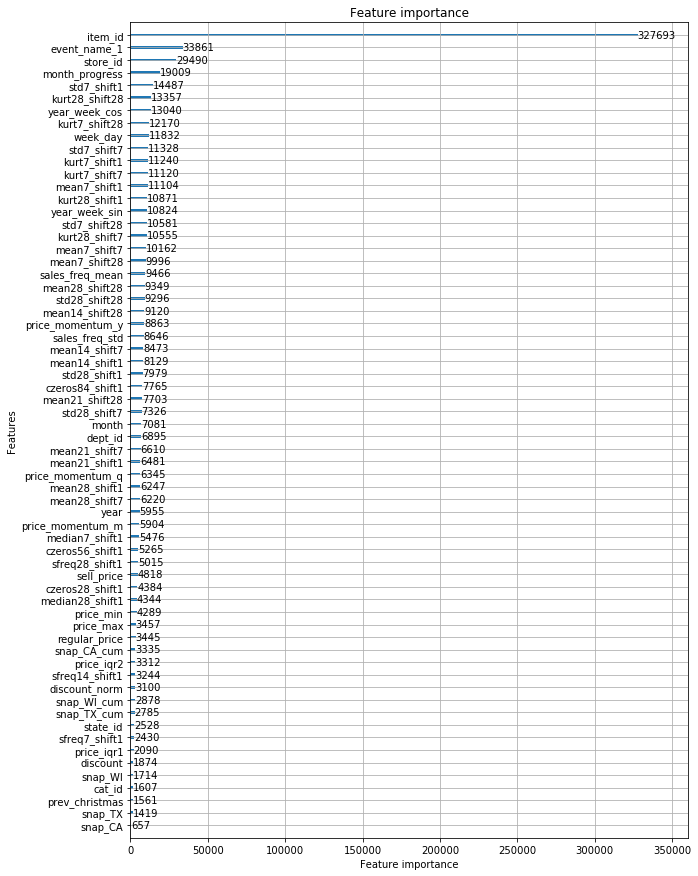

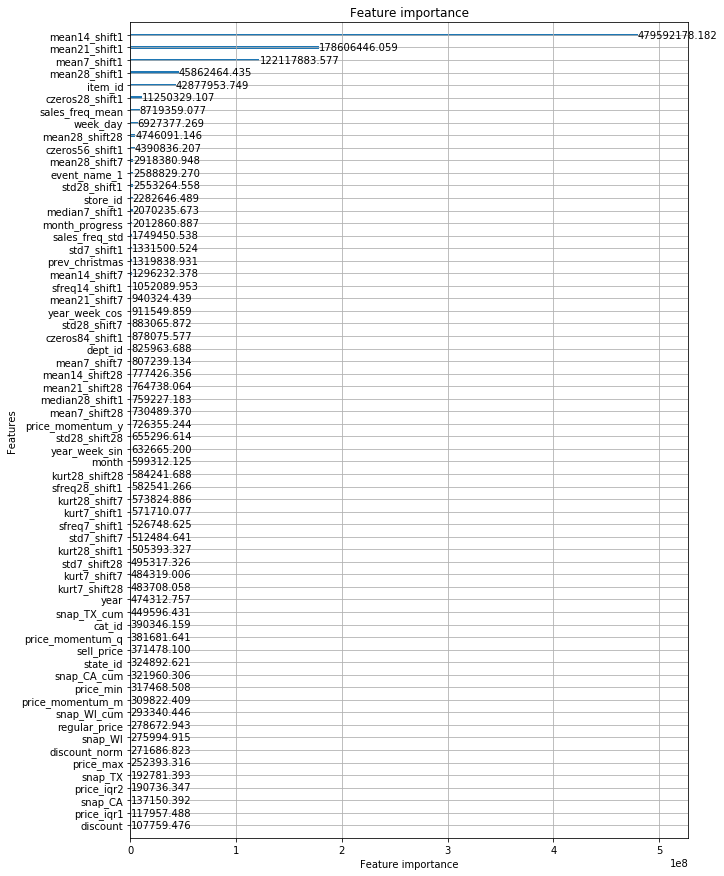

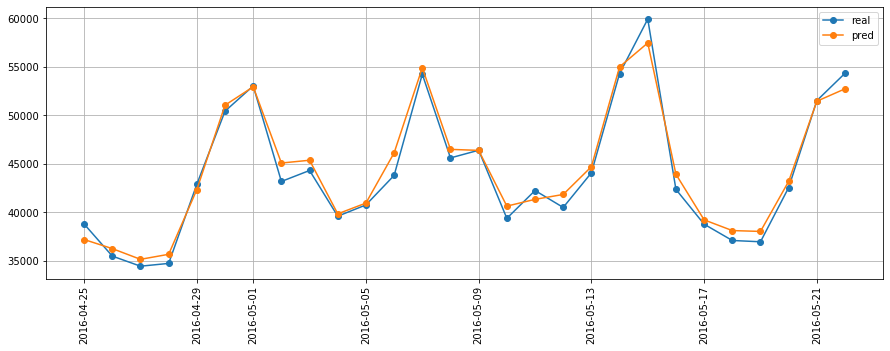

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 3 #
####################################################################################################
Building the features
Elapsed time: 12.925894963741303 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.755053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 64
Elapsed time: 51.71780642271042 [min]
Predicting
Elapsed time: 14.768237368265789 [min]
wrmsse: 0.4907072385296747
wrmsseL12: 0.8166155065409186
{'root': 0.21143271440081335, ('state_id',): 0.3231295963160867, ('store_id',): 0.41842321967769, ('cat_id',): 0.2

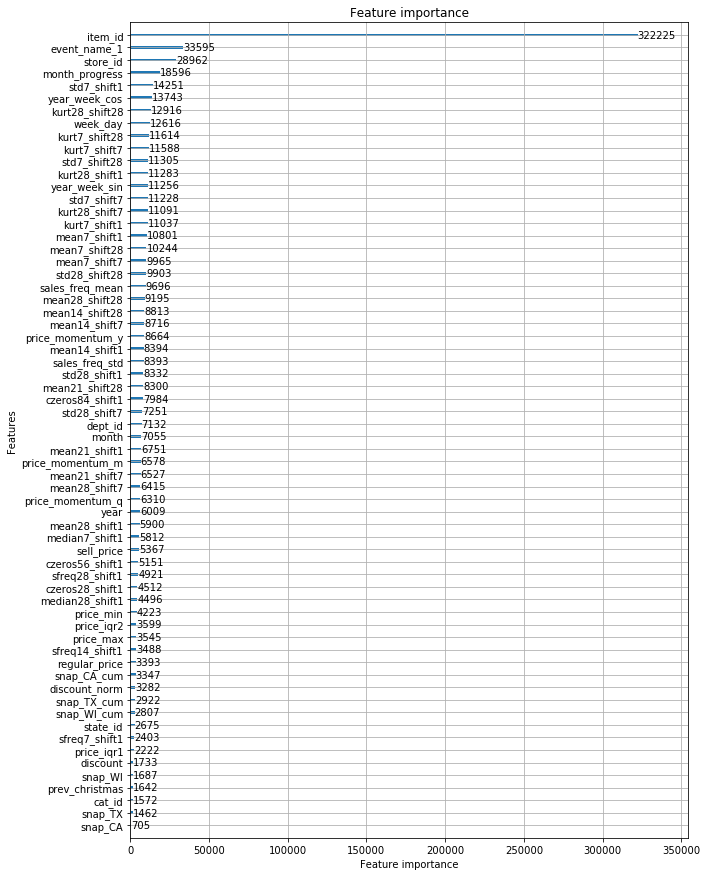

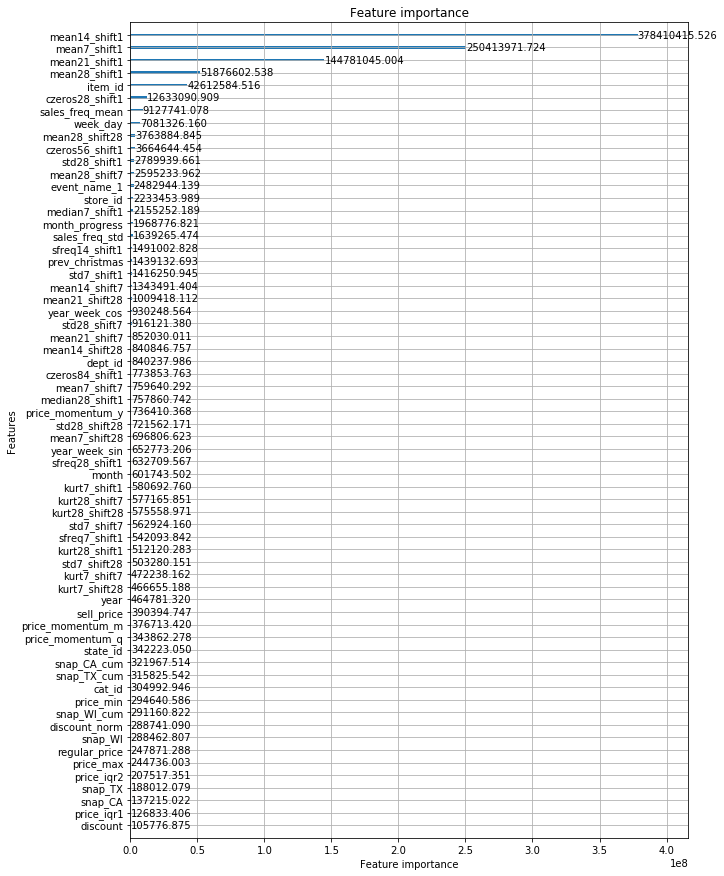

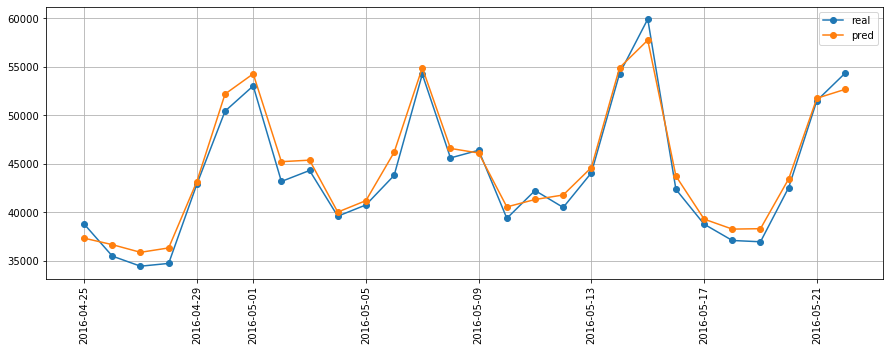

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 5 #
####################################################################################################
Building the features
Elapsed time: 14.031282564004263 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.101892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 64
Elapsed time: 53.84519570668538 [min]
Predicting
Elapsed time: 14.705259438355764 [min]
wrmsse: 0.4887856646872187
wrmsseL12: 0.8165952727744201
{'root': 0.19743030819458884, ('state_id',): 0.3120216765138011, ('store_id',): 0.42885833132194806, ('cat_id',): 

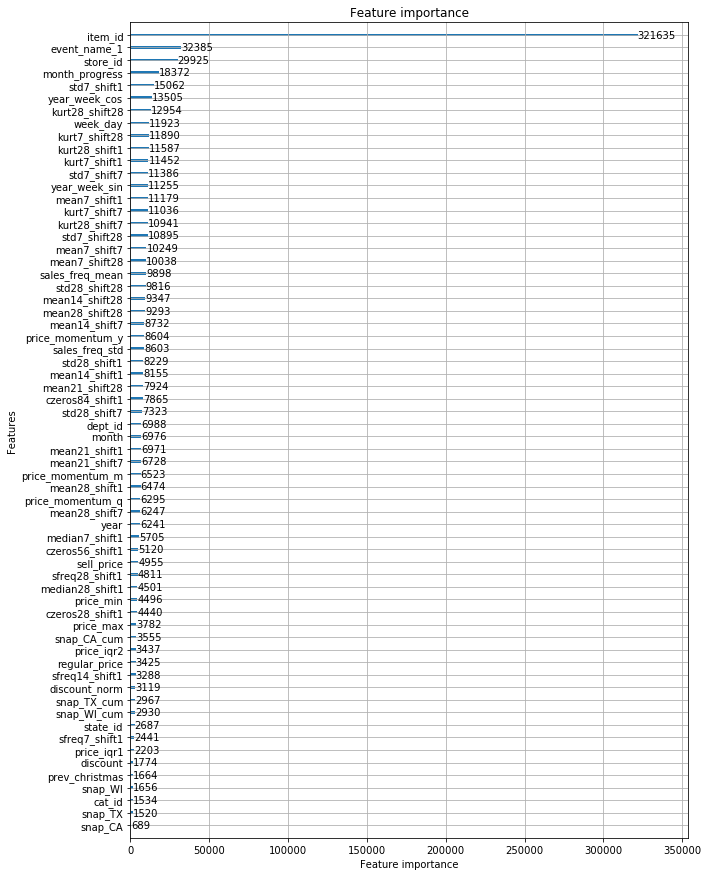

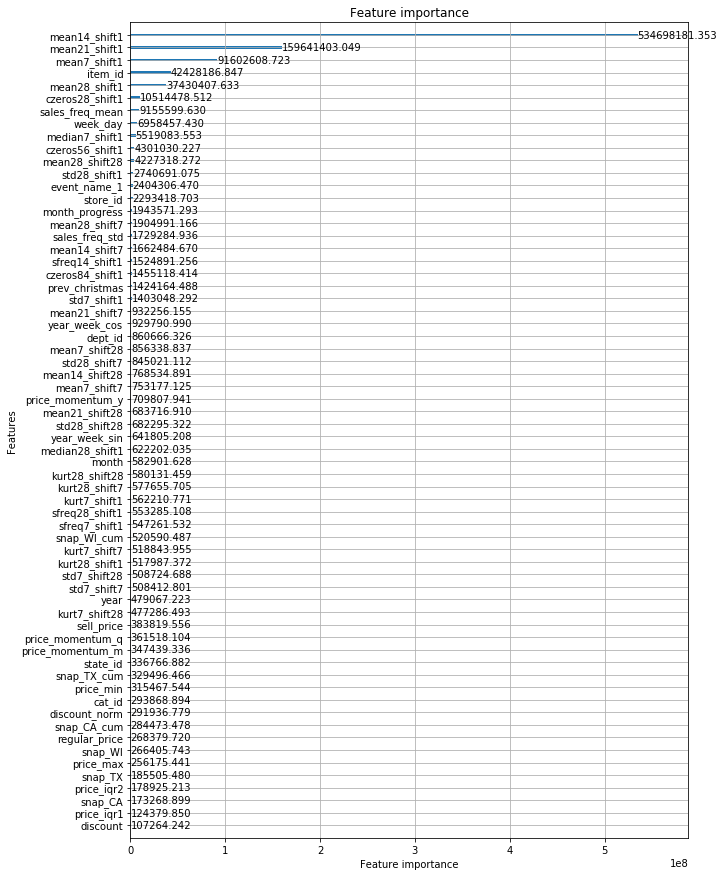

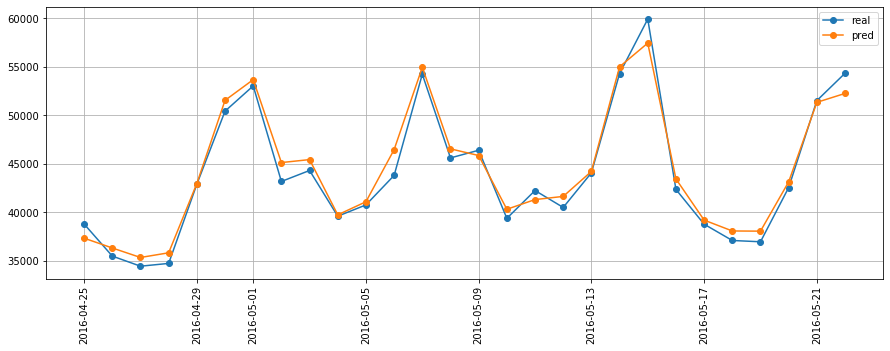

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 7 #
####################################################################################################
Building the features
Elapsed time: 13.336608529090881 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.857783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 64
Elapsed time: 51.978853452205655 [min]
Predicting
Elapsed time: 14.82211525440216 [min]
wrmsse: 0.49067542002650616
wrmsseL12: 0.8161873935092623
{'root': 0.20810699827268153, ('state_id',): 0.31466808209464064, ('store_id',): 0.43088305300151686, ('cat_id',)

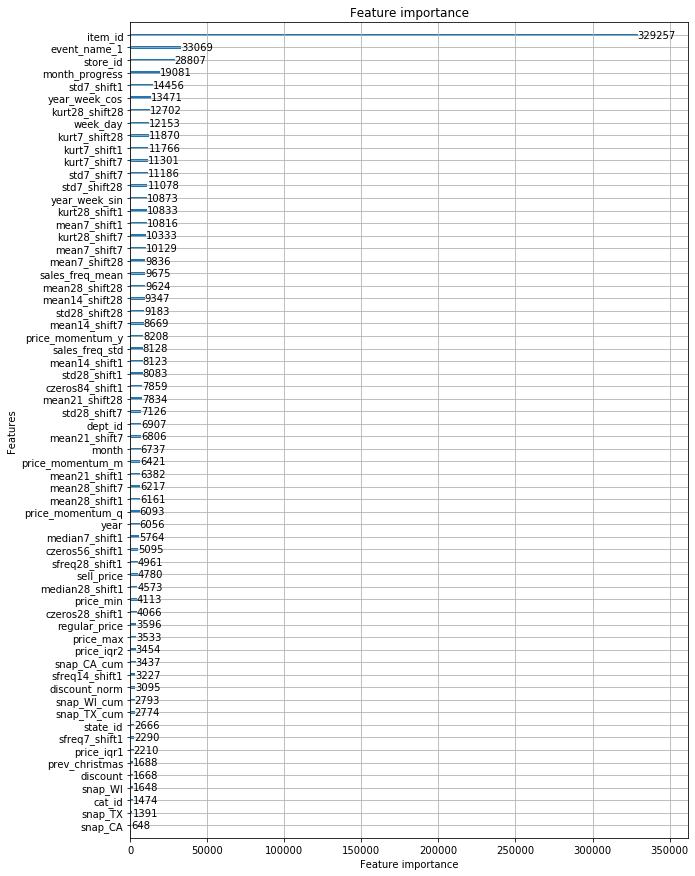

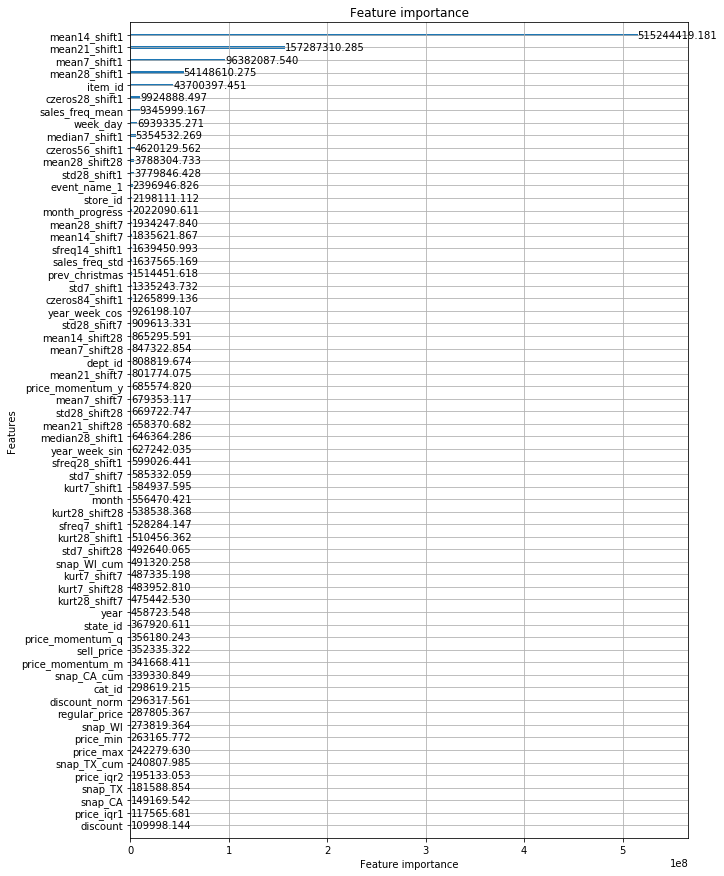

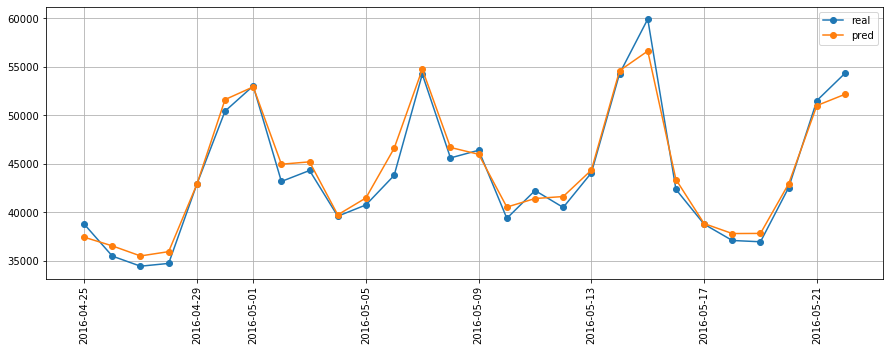

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 11 
####################################################################################################
Building the features
Elapsed time: 13.748914202054342 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.623684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 64
Elapsed time: 52.52841505606969 [min]
Predicting
Elapsed time: 14.80284507671992 [min]
wrmsse: 0.48583983897698785
wrmsseL12: 0.8168814955520143
{'root': 0.19121690295340146, ('state_id',): 0.30547799261133335, ('store_id',): 0.4326457070051484, ('cat_id',): 

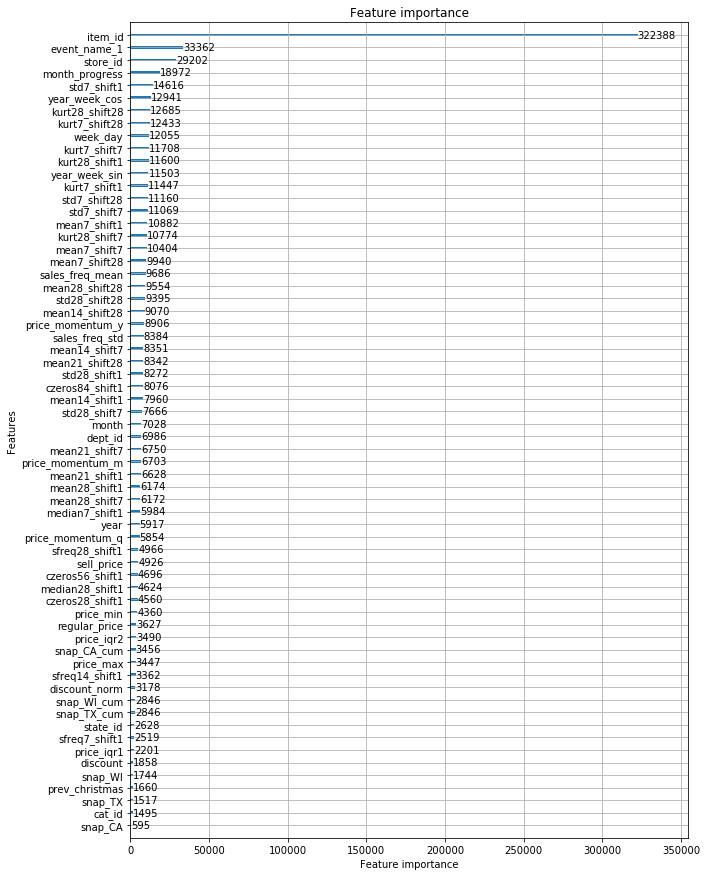

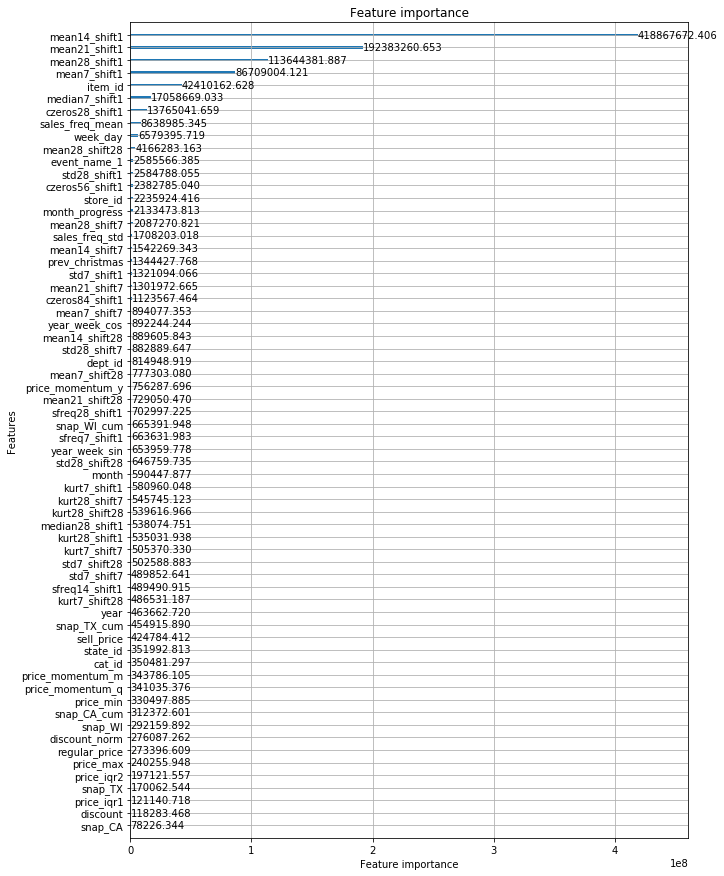

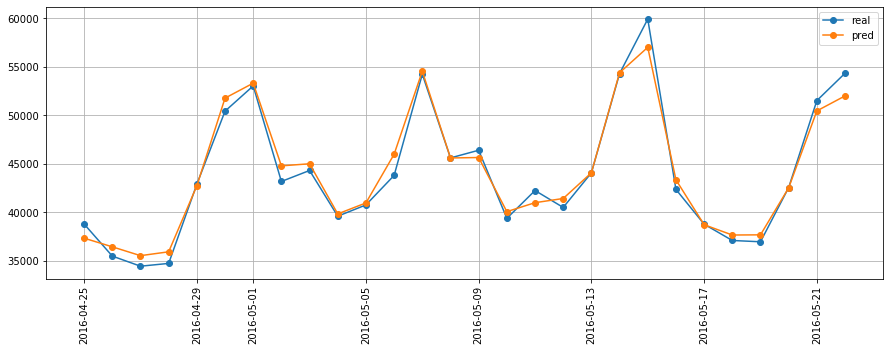

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 13 
####################################################################################################
Building the features
Elapsed time: 13.841233579317729 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.008836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 64


In [ ]:
%%time
SEEDS = [2,3,5,7,11,13,17,19]
forecast_by_fold = list()

for seed in SEEDS:    
    print("#"*100)
    print(f" Validation period: {valid_period} - seed: {seed} ".center(100, "#"))
    print("#"*100)

    valid_start = valid_period[0]
    valid_end = valid_period[1]
    _train_data = data.query("ds < @valid_start").reset_index(drop=True)

    print("Building the features")
    tic = time.time()
    model_kwargs["model_params"]["seed"] = seed
    model_level12 = LightGBMForecaster(**model_kwargs)
    model_level12.prepare_features(train_data=_train_data)
    model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
    model_level12.train_features = reduce_mem_usage(model_level12.train_features)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    ts_id_in_train = model_level12.train_features.ts_id.unique()
    valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
    evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

    print("Fitting the model")
    tic = time.time()
    model_level12.fit()
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,15))
    lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,15))

    print("Predicting")
    tic = time.time()
    forecast = model_level12.predict(valid_data.drop("y", axis=1), recursive=True)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
    wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
    print("wrmsse:", wrmsse)
    print("wrmsseL12:", wrmsseL12)
    print(evaluator.eval1.errors_by_level)

    mrg = (valid_data.groupby(["ds"])["y"].sum().reset_index()
           .merge(forecast.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
    plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()

    forecast_by_fold.append(forecast)
    del model_level12, _train_data, valid_data, evaluator
    gc.collect()

In [11]:
for i,forecast in enumerate(forecast_by_fold):
    forecast.to_csv(f"../output/forecast-f4-s{i}.csv", index=False)

In [18]:
ts_id_in_train = data.query("ds < @valid_start").ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

In [44]:
for seed,forecast in enumerate(forecast_by_fold):
    print("#"*100)
    print(f" seed: {seed} ".center(100, "#"))
    print("#"*100)
    
    wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
    wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
    print("wrmsse:", wrmsse)
    print("wrmsseL12:", wrmsseL12)
    print(evaluator.eval1.errors_by_level)

####################################################################################################
############################################# seed: 0 ##############################################
####################################################################################################
wrmsse: 0.4903467142665861
wrmsseL12: 0.8173534161113774
{'root': 0.1902929355533325, ('state_id',): 0.31099972403305104, ('store_id',): 0.43942531157618175, ('cat_id',): 0.25198193697451854, ('dept_id',): 0.3590291213840337, ('state_id', 'cat_id'): 0.3739436171528392, ('state_id', 'dept_id'): 0.4620292348164825, ('store_id', 'cat_id'): 0.5002191159292707, ('store_id', 'dept_id'): 0.5850075159717888, ('item_id',): 0.7871063443223043, ('item_id', 'state_id'): 0.8067722973738531, ('item_id', 'store_id'): 0.8173534161113774}
####################################################################################################
############################################# seed: 1 ##############

In [42]:
forecast_agg = forecast_by_fold[0].copy(deep=True)
forecast_agg["y_pred"] = trimean([fcst.y_pred for fcst in forecast_by_fold], axis=0)

In [40]:
forecast_trunc = forecast_by_fold[7].copy(deep=True)
idx = forecast_trunc.query("y_pred < 0.1").index
forecast_trunc.loc[idx, "y_pred"] = 0

In [43]:
# trimean
wrmsse = evaluator.eval1._evaluate(forecast_agg.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(forecast_agg.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.48291495308698607
wrmsseL12: 0.814461040332228
{'root': 0.18893553934683327, ('state_id',): 0.3054398700157524, ('store_id',): 0.4241597716379659, ('cat_id',): 0.24760395872935237, ('dept_id',): 0.34958337855185506, ('state_id', 'cat_id'): 0.3666131708617997, ('state_id', 'dept_id'): 0.4520767914238921, ('store_id', 'cat_id'): 0.4860933316924522, ('store_id', 'dept_id'): 0.5701613103489214, ('item_id',): 0.7852384866379203, ('item_id', 'state_id'): 0.8046127874648599, ('item_id', 'store_id'): 0.814461040332228}


***
## training without early stopping

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Building the features
Elapsed time: 12.561970535914103 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.257310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8786
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 82
Elapsed time: 29.632428594430287 [min]
Predicting
Elapsed time: 14.555029443899791 [min]
wrmsse: 0.4867253066395207
wrmsseL12: 0.8160198497354868
{'root': 0.2038058157118852, ('state_id',): 0.3050456266016901, ('store_id',): 0.4165173057089899, ('cat_id',): 0

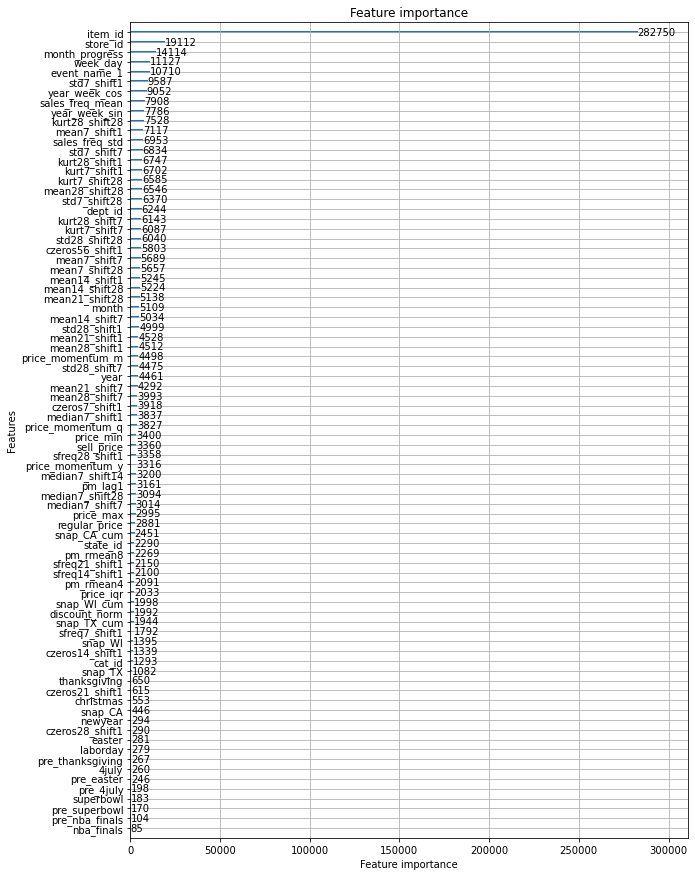

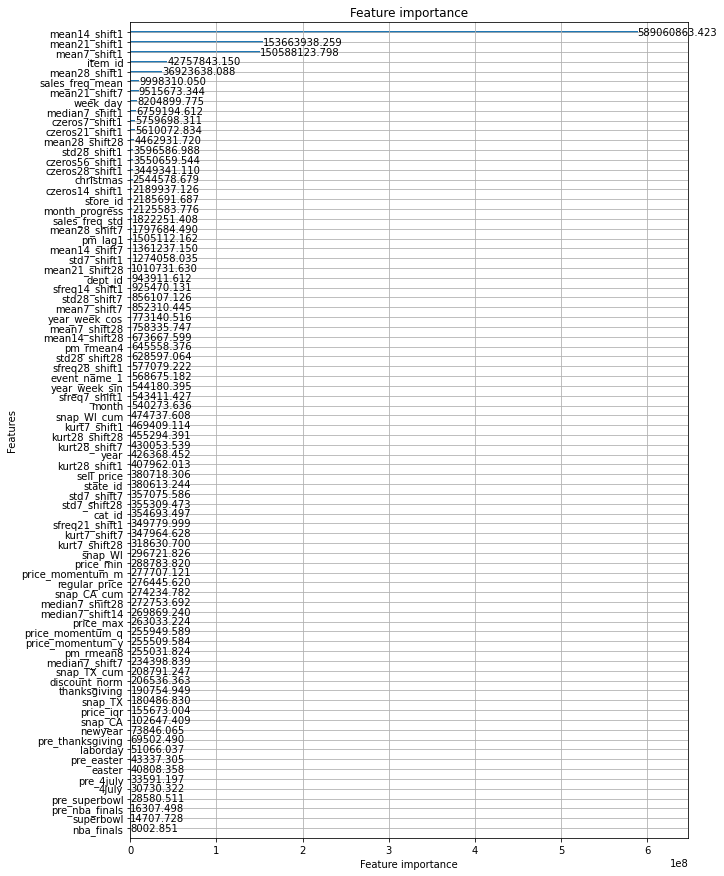

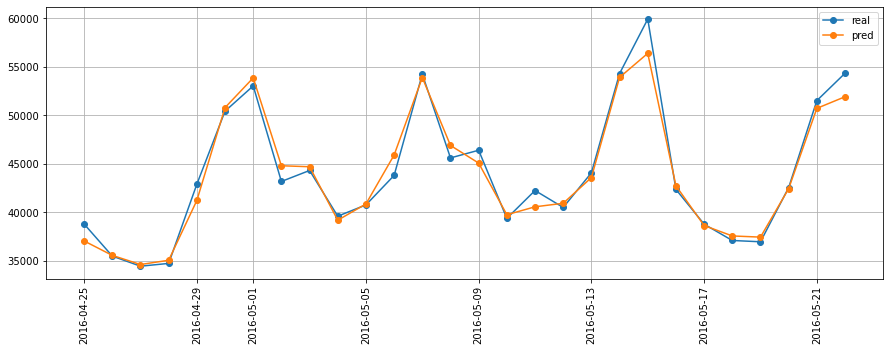

CPU times: user 9h 18min 34s, sys: 51min 10s, total: 10h 9min 45s
Wall time: 1h 51s


36535

In [6]:
%%time
# 600

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds < @valid_start").reset_index(drop=True)

print("Building the features")
tic = time.time()
model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data)
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
gc.collect()
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

ts_id_in_train = model_level12.train_features.ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

print("Fitting the model")
tic = time.time()
model_level12.fit()
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,15))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,15))

# thresh_value
input_features = model_level12.input_features
predict_data = model_level12.train_features.query("no_stock_days >= 28").loc[:, input_features]
predictions = model_level12.model.model.predict(predict_data)
thresh_value = trim_mean(predictions, proportiontocut=0.05)
def bias_corr_func(x, tv=thresh_value):
    x[x < tv] = 0
    return x
print("Predicting")
tic = time.time()
forecast = model_level12.predict(valid_data.drop("y", axis=1), recursive=True, bias_corr_func=bias_corr_func)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

mrg = (valid_data.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

In [8]:
forecast.to_csv("forecast-f4.csv", index=False)

***
## training with early stopping

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.996995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6153
[LightGBM] [Info] Number of data points in the train set: 24364230, number of used features: 71
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.875242	valid_0's wrmsse: 1.11619
[50]	valid_0's wrmsseL12: 0.803201	valid_0's wrmsse: 0.664444
[75]	valid_0's wrmsseL12: 0.793149	valid_0's wrmsse: 0.55237
[100]	valid_0's wrmsseL12: 0.790699	valid_0's wrmsse: 0.520644
[125]	valid

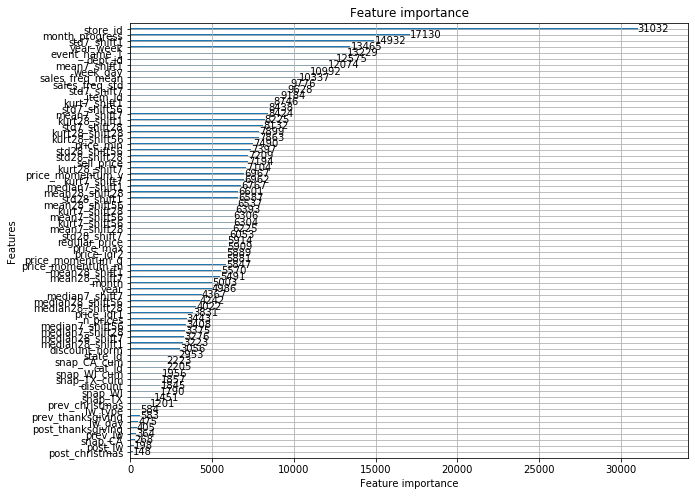

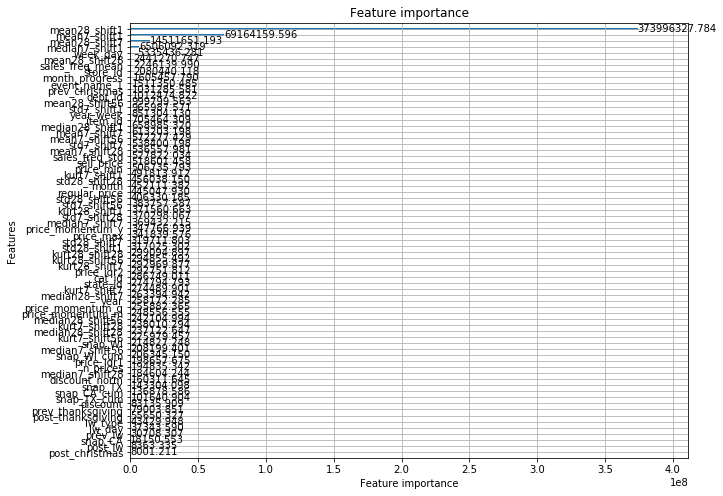

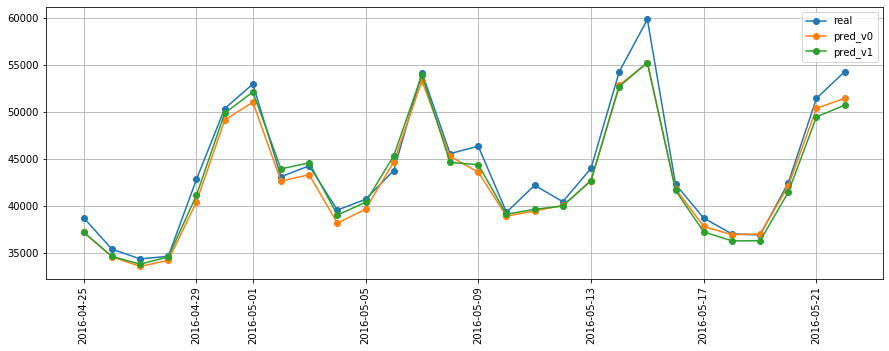

CPU times: user 7h 27min 44s, sys: 1h 15min 28s, total: 8h 43min 12s
Wall time: 1h 59min 20s


32876

In [10]:
%%time

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds <= @valid_end").reset_index(drop=True)
_valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
ts_id_in_train = model_level12.train_features.ts_id.unique()
model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

print("Fitting the model")
tic = time.time()
evaluator = Evaluator(model_level12.valid_features)
model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

valid_dataframe = (model_level12.valid_features
                   .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                   .copy())
evaluator = WRMSSEEvaluator(valid_dataframe)

print("Predicting with ground thruth lagged values")
tic = time.time()
forecast_f4_v0 = (model_level12.valid_features
                  .loc[:, ["ds"]+model_level12.ts_uid_columns]
                  .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_f4_v1 = model_level12.predict(valid_data, recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

In [5]:
forecast = pd.read_csv("../output/forecast-f4.csv", parse_dates=["ds"])

***
# Trend Correction

***
## Level 1

In [10]:
mrg_level1 = mrg_level1 = mrg.groupby(["ds"])[["y","y_pred"]].sum().reset_index()mrg.groupby(["ds"])[["y","y_pred"]].sum().reset_index()

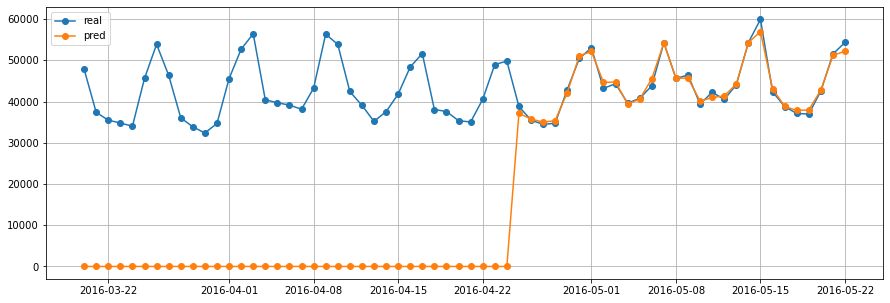

In [11]:
df = mrg_level1.query("ds >= '2016-03-20'")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.legend(loc="best")
plt.show()

In [12]:
predict_data = make_time_range("2011-04-24", "2016-05-22", "D")

In [13]:
import numpy as np
import pandas as pd
from supersmoother import SuperSmoother

class TrendEstimator():
    
    def __init__(self, primary_bandwidths, middle_bandwidth, final_bandwidth, alpha):
        self.primary_bandwidths = primary_bandwidths
        self.middle_bandwidth = middle_bandwidth
        self.final_bandwidth = final_bandwidth
        self.alpha = alpha
    
    def fit(self, data):
        min_date = data.ds.min()
        time_idx = (data.ds - min_date).apply(lambda x: x.days).values
        time_values = data.y.values
        
        # from bandwidths to spans
        kwargs = {
            "alpha":self.alpha,
            "primary_spans":self.primary_bandwidths/data.shape[0],
            "middle_span":self.middle_bandwidth/data.shape[0],
            "final_span":self.final_bandwidth/data.shape[0],   
        }
        trend_model = SuperSmoother(**kwargs)
        trend_model.fit(time_idx, time_values)
        
        self.min_date = min_date
        self.trend_model = trend_model
    
    def predict(self, data):
        time_idx = (data.ds - self.min_date).apply(lambda x: x.days).values
        trend = self.trend_model.predict(time_idx)
        return pd.DataFrame({"ds":data.ds, "trend":trend})

In [14]:
df = pd.concat([
    mrg_level1.query("ds < '2016-04-25'").loc[:, ["ds","y"]],
    mrg_level1.query("ds >= '2016-04-25'").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
    ignore_index=True)

trend_model1 = TrendEstimator(primary_bandwidths=np.arange(15, 34), middle_bandwidth=27, final_bandwidth=34, alpha=8)
trend_model1.fit(df)
trend1 = trend_model1.predict(predict_data)

In [15]:
df = mrg_level1.query("ds < '2016-04-25'").loc[:, ["ds","y"]]

trend_model2 = TrendEstimator(primary_bandwidths=np.arange(74, 77), middle_bandwidth=110, final_bandwidth=87, alpha=4)
trend_model2.fit(df)
trend2 = trend_model2.predict(predict_data)

In [16]:
_mrg_level1 = (mrg_level1
              .merge(trend1, on="ds")
              .merge(trend2, on="ds")
             )
_mrg_level1

,ds,y,y_pred,trend_x,trend_y
0,2011-04-24,24018.0,0.000000,23843.979084,24364.032739
1,2011-04-25,20004.0,0.000000,23799.350594,24357.168786
2,2011-04-26,18113.0,0.000000,23751.014413,24350.329597
3,2011-04-27,17929.0,0.000000,23706.597669,24344.284072
4,2011-04-28,18145.0,0.000000,23666.435731,24340.411777
...,...,...,...,...,...
1851,2016-05-18,37096.0,37828.920707,45177.188118,43580.377077
1852,2016-05-19,36963.0,37942.929058,45298.341634,43605.706476
1853,2016-05-20,42552.0,42780.984258,45415.469854,43631.035875
1854,2016-05-21,51518.0,51156.085638,45486.421126,43656.365274


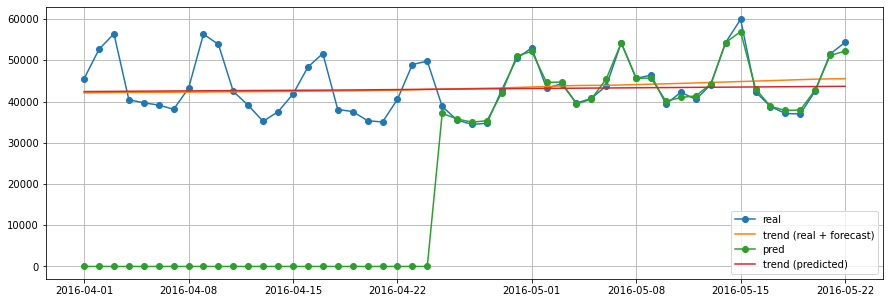

In [17]:
df = _mrg_level1.query("ds >= '2016-04-01'")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
plt.grid()
plt.legend(loc="best")
plt.show()

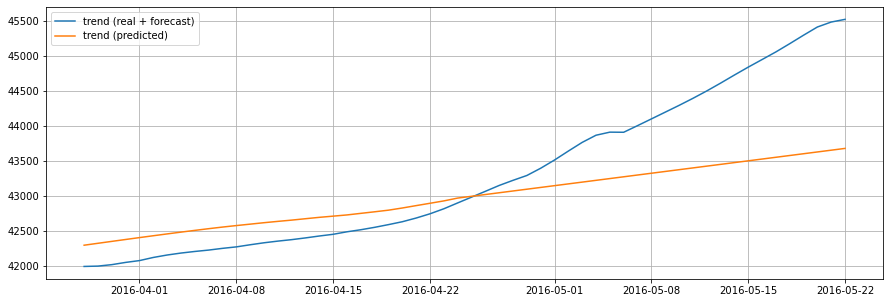

In [18]:
df = _mrg_level1.query("ds >= '2016-03-28'")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [19]:
mrg_level3 = mrg.groupby(["ds","store_id"])[["y","y_pred"]].sum().reset_index()

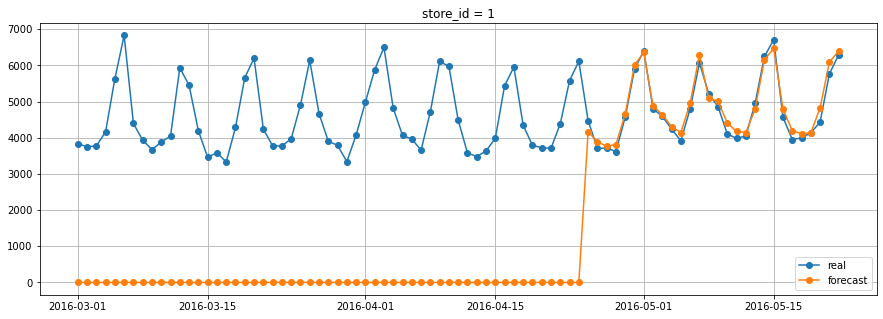

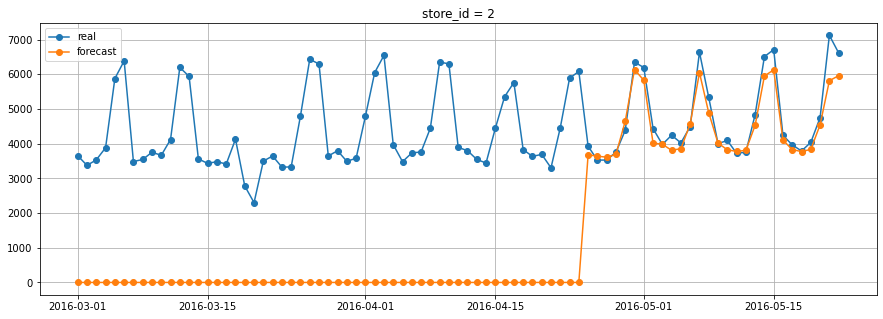

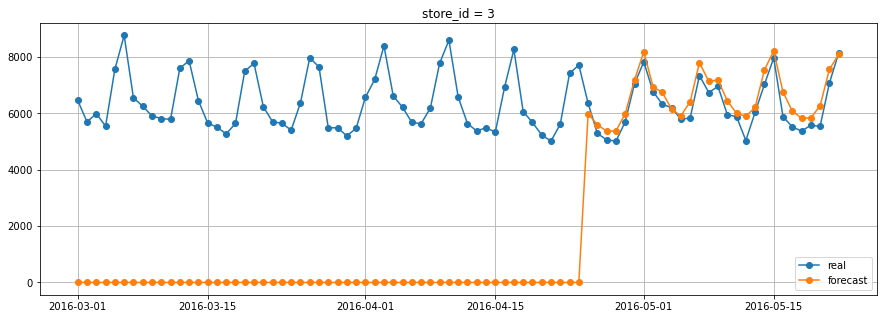

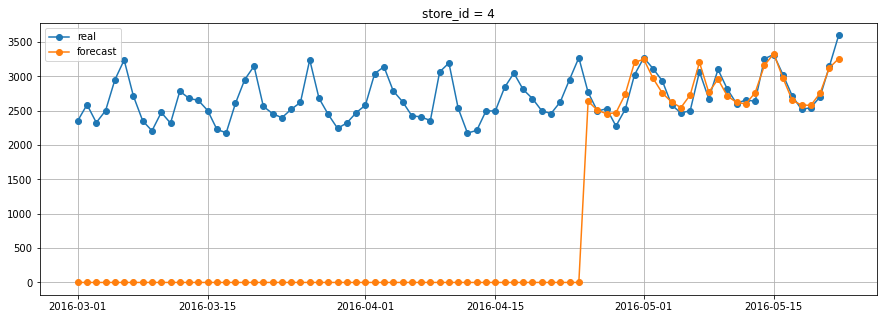

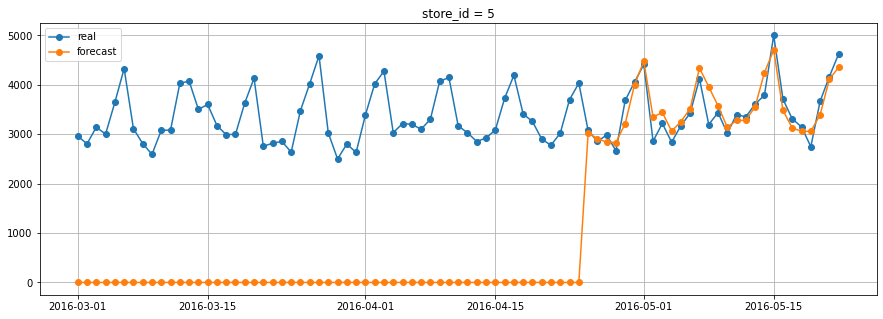

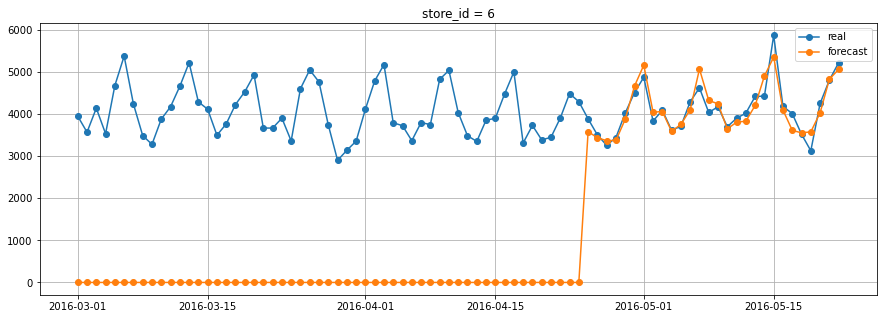

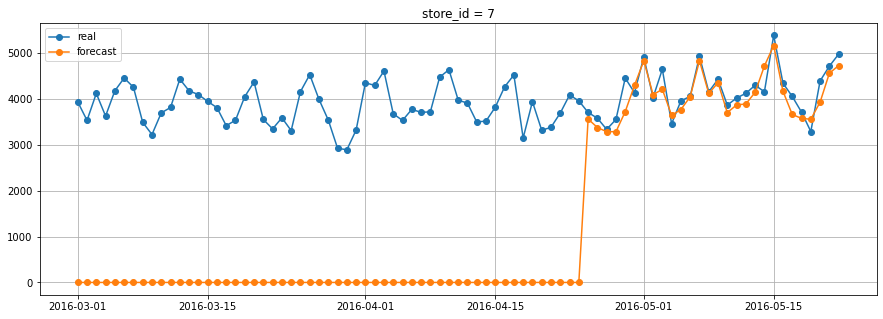

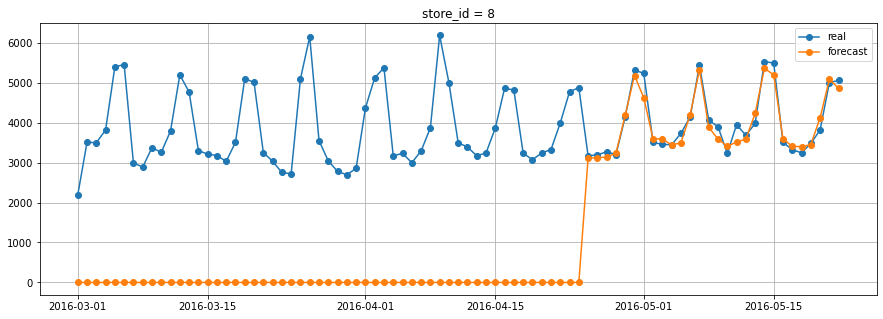

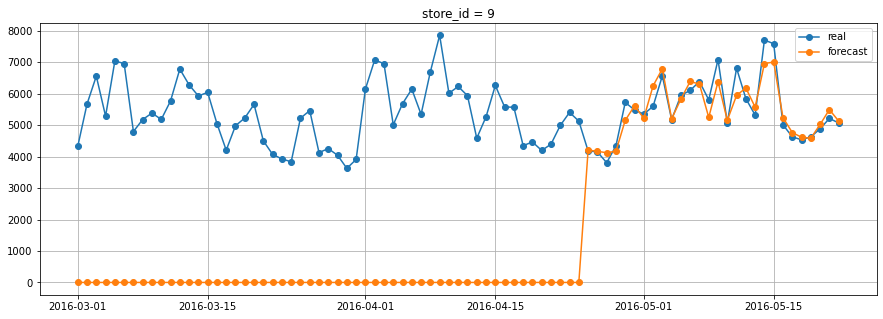

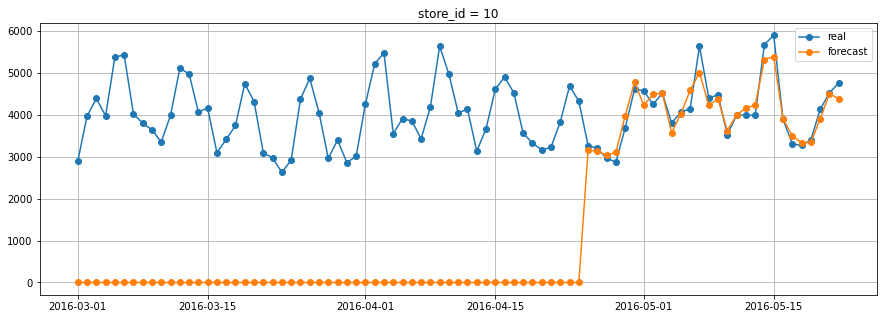

In [20]:
for store_id in mrg_level3.store_id.unique():
    df = mrg_level3.query("store_id == @store_id & ds >= '2016-03-01'")

    plt.figure(figsize=(15,5))
    plt.title(f"store_id = {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="forecast")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

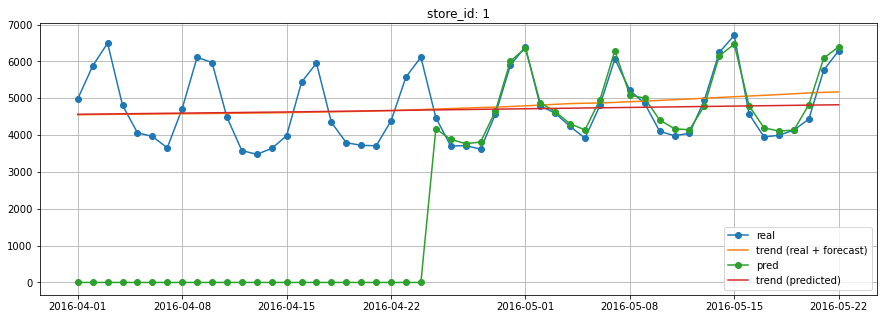

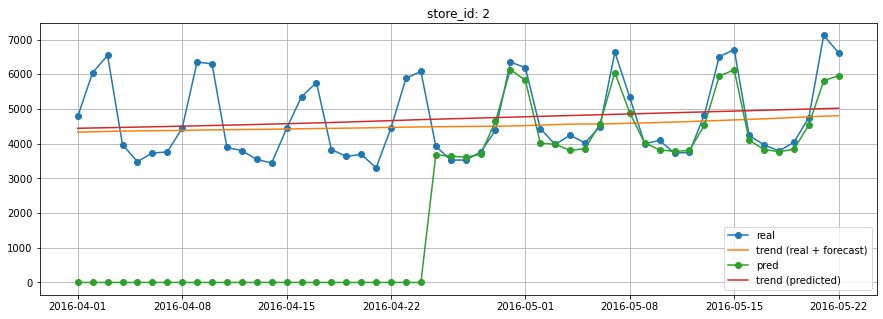

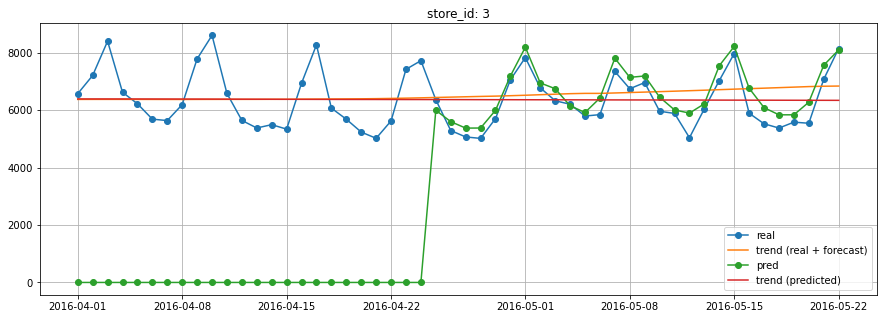

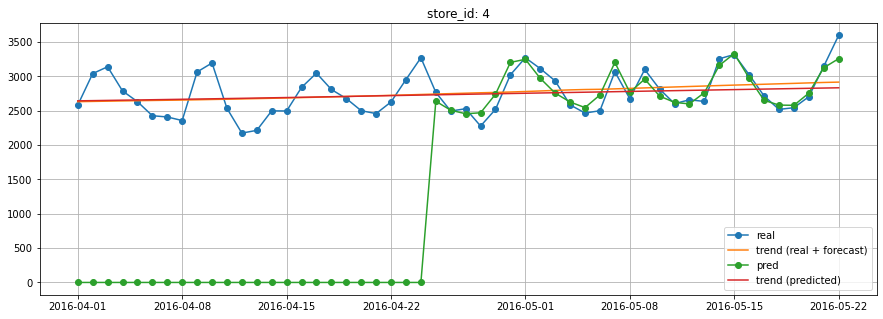

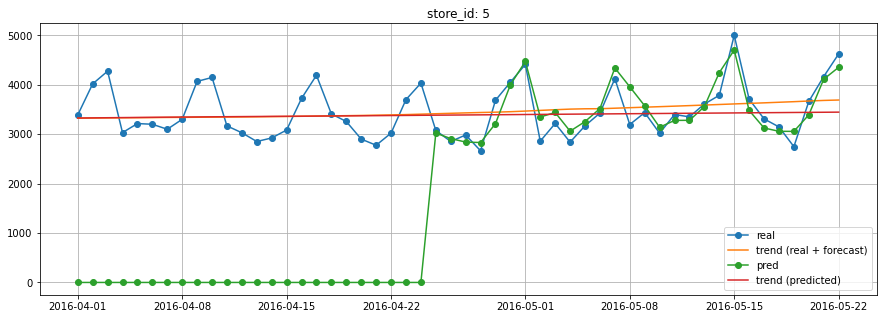

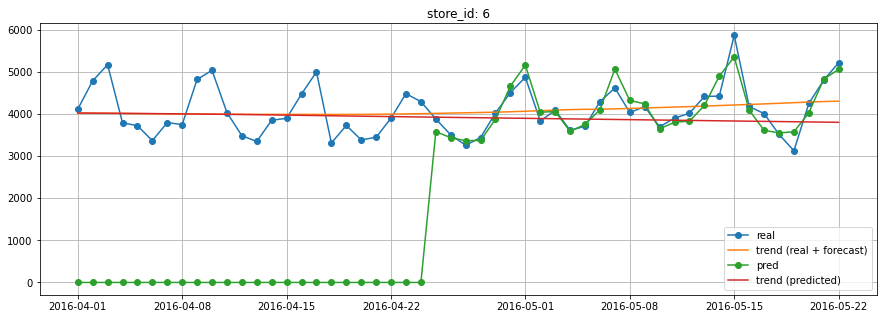

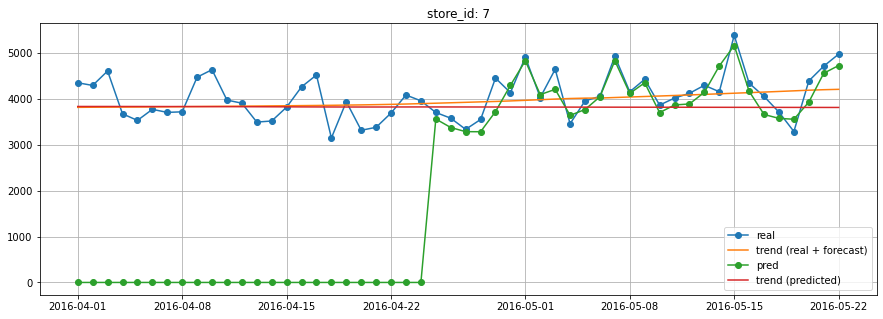

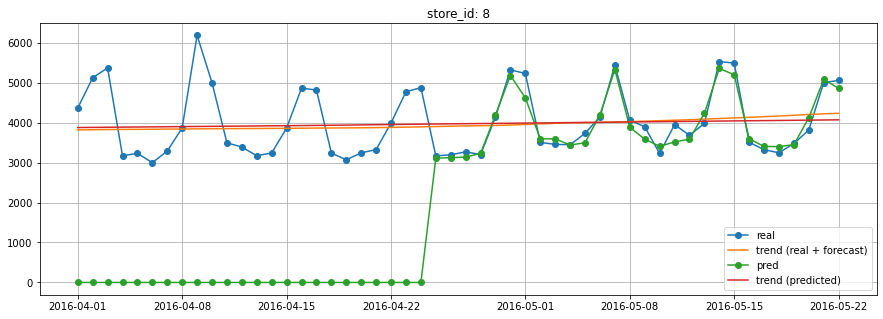

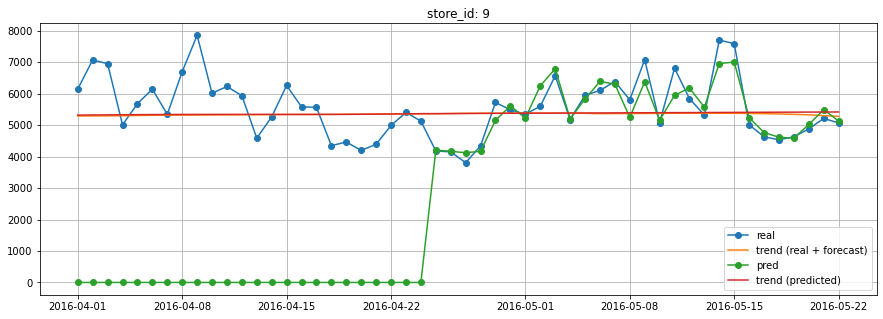

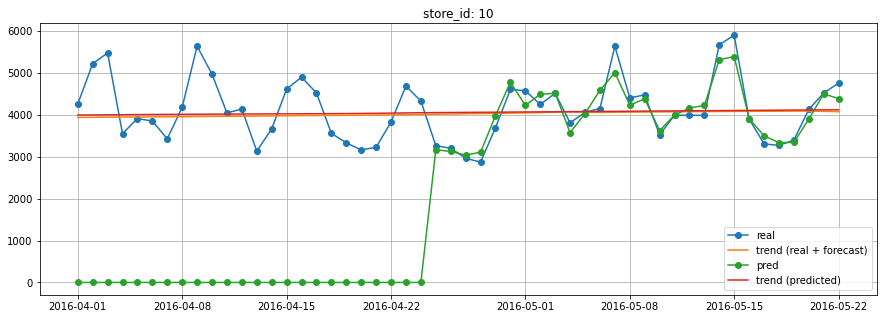

In [21]:
for store_id in mrg_level3.store_id.unique():
    df = pd.concat([
        mrg_level3.query("store_id == @store_id & ds < '2016-04-25'").loc[:, ["ds","y"]],
        mrg_level3.query("store_id == @store_id & ds >= '2016-04-25'").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
        ignore_index=True)

    trend_model1 = TrendEstimator(primary_bandwidths=np.arange(15, 34), 
                                  middle_bandwidth=27, 
                                  final_bandwidth=34, 
                                  alpha=8)
    trend_model1.fit(df)
    trend1 = trend_model1.predict(predict_data)
    
    df = mrg_level3.query("store_id == @store_id & ds < '2016-04-25'").loc[:, ["ds","y"]]

    trend_model2 = TrendEstimator(primary_bandwidths=np.arange(74, 77), 
                                  middle_bandwidth=110, 
                                  final_bandwidth=87, 
                                  alpha=4)
    trend_model2.fit(df)
    trend2 = trend_model2.predict(predict_data)
    
    _mrg_level3 = (mrg_level3.query("store_id == @store_id")
                  .merge(trend1, on="ds")
                  .merge(trend2, on="ds")
                 )
    
    df = _mrg_level3.query("ds >= '2016-04-01'")

    plt.figure(figsize=(15,5))
    plt.title(f"store_id: {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    

***